# Models to predict the mortality of sepsis patients

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import datetime
from time import time
import import_ipynb
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import visuals as vs

## Extracting the clean data  

In [93]:
import os
os.getcwd()
os.chdir(r'C:\Users\skura\Desktop\HAP\Project')
labevents = pd.read_csv(r'clean_sepsis_feature_list.csv')

sepsis_features = pd.read_csv('clean_sepsis_feature_list.csv')

In [94]:
sepsis_features.columns

Index(['Unnamed: 0', 'subject_id', 'hadm_id', 'Alanine Aminotransferase (ALT)',
       'Alkaline Phosphatase', 'Anion Gap', 'Asparate Aminotransferase (AST)',
       'Basophils', 'Bicarbonate', 'Bilirubin, Total', 'Calcium, Total',
       'Chloride', 'Creatinine', 'Eosinophils', 'Glucose', 'Hematocrit',
       'Hemoglobin', 'INR(PT)', 'Lactate', 'Lymphocytes', 'MCH', 'MCHC', 'MCV',
       'Magnesium', 'Monocytes', 'Neutrophils', 'PT', 'PTT', 'Phosphate',
       'Platelet Count', 'Potassium', 'RDW', 'Red Blood Cells', 'Sodium',
       'Specific Gravity', 'Urea Nitrogen', 'White Blood Cells', 'pH',
       'admission_type', 'insurance', 'ethnicity', 'death_period', 'gender',
       'age', 'BLOOD CULTURE', 'MRSA SCREEN', 'SPUTUM', 'STOOL', 'SWAB',
       'URINE', 'num_of_infections'],
      dtype='object')

In [95]:
sepsis_features.drop(['Unnamed: 0'],axis=1,inplace=True)

In [97]:
sepsis_features.shape

(1178, 50)

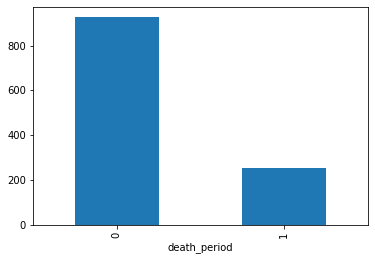

In [98]:
sepsis_features.groupby('death_period').size().plot.bar()

In [99]:
sepsis_features.groupby('death_period').size()

death_period
0    926
1    252
dtype: int64

In [6]:
sepsis_features.num_of_infections.describe()

count    1178.000000
mean        1.224109
std         1.553037
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        14.000000
Name: num_of_infections, dtype: float64

In [7]:
sepsis_features.select_dtypes(exclude=['floating','integer']).head()
sepsis_features = pd.get_dummies(sepsis_features)

### Analyzing the co-relation and importance of all features together

### Shuffle and Split Data

Now all categorical variables have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 90% of the data will be used for training and 10% for testing. We are doing 90% and 10% because our dataset is small.

In [8]:
# Import train_test_split
from sklearn.model_selection import train_test_split


tr, ts = train_test_split(sepsis_features, test_size=0.2)

In [9]:
cls = list(sepsis_features.columns)
cls.remove('subject_id')
cls.remove('hadm_id')
cls.remove('death_period')

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score


In [181]:
lr = LogisticRegression(solver='lbfgs', C=0.9, max_iter=1000)
lr.fit(tr[cls],tr['death_period'])
probs = lr.predict_proba(ts[cls])[:,1]
#fpr,tpr,thresholds = roc_curve(ts['death_period'],probs)
#auc =auc(fpr,tpr)

In [182]:
probs_lr_tr = lr.predict_proba(tr[cls])[:,1]
probs_lr_ts = lr.predict_proba(ts[cls])[:,1]


(array([104.,  50.,  24.,  12.,  20.,   8.,   5.,   5.,   6.,   2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 1 Patch objects>)

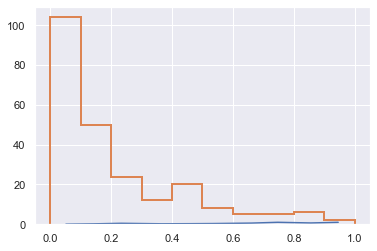

In [185]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
cur = calibration_curve(ts['death_period'],probs_lr_ts, n_bins=10)
from matplotlib import pyplot as plt

plt.plot(cur[1],cur[0])
plt.hist(probs_lr_ts, range=(0, 1), bins=10, histtype="step", lw=2)

In [193]:
lr_iso =  CalibratedClassifierCV(lr, cv=5, method='isotonic')
lr_sig = CalibratedClassifierCV(lr, cv=5, method='sigmoid')

In [195]:
lr_iso.fit(tr[cls], tr['death_period'])


# In[57]:


lr_sig.fit(tr[cls], tr['death_period'])



CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.9, max_iter=1000),
                       cv=5)

In [196]:
probs_lr_tr_iso = lr_iso.predict_proba(tr[cls])[:,1]
probs_lr_ts_iso = lr_iso.predict_proba(ts[cls])[:,1]
probs_lr_tr_sig = lr_sig.predict_proba(tr[cls])[:,1]
probs_lr_ts_sig = lr_sig.predict_proba(ts[cls])[:,1]

In [197]:
cur_rf_tr_iso = calibration_curve(tr['death_period'],probs_lr_tr_iso, n_bins=10)
cur_rf_ts_iso = calibration_curve(ts['death_period'],probs_lr_ts_iso, n_bins=10)

cur_rf_tr_sig = calibration_curve(tr['death_period'],probs_lr_tr_sig, n_bins=10)
cur_rf_ts_sig = calibration_curve(ts['death_period'],probs_lr_ts_sig, n_bins=10)

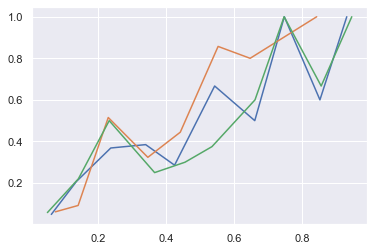

In [198]:
plt.plot(cur_rf_ts_iso[1],cur_rf_ts_iso[0])
plt.plot(cur_rf_ts_sig[1],cur_rf_ts_sig[0])
plt.plot(cur[1],cur[0])

In [38]:

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
lr = LogisticRegression(solver='lbfgs', C=0.01, max_iter=1000)
lr.fit(tr[cls],tr['death_period'])
y_pred = rf.predict(ts[cls])
print("Accuracy score : {}".format(accuracy_score(ts['death_period'], y_pred)))
print("Classification Report : \n {}".format(classification_report(ts['death_period'], y_pred)))
print("Confusion Matrix : \n {}".format(confusion_matrix(ts['death_period'], y_pred)))

Accuracy score : 0.7923728813559322
Classification Report : 
               precision    recall  f1-score   support

           0       0.79      0.98      0.88       181
           1       0.75      0.16      0.27        55

    accuracy                           0.79       236
   macro avg       0.77      0.57      0.57       236
weighted avg       0.78      0.79      0.74       236

Confusion Matrix : 
 [[178   3]
 [ 46   9]]


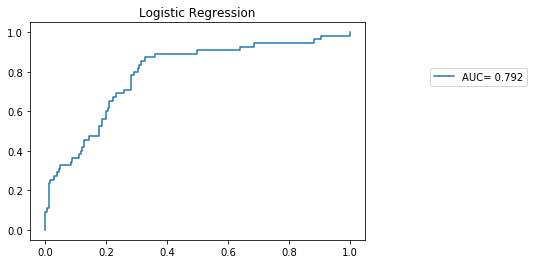

In [39]:
plt.title('Logistic Regression')
plt.plot(fpr, tpr,label = "AUC= "+str(round((auc),3)))
plt.legend(loc='center right', bbox_to_anchor=(1,0.5,0.5,0.5))

In [12]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(tr[cls],tr['death_period'])
probs = rf.predict_proba(ts[cls])[:,1]
fpr,tpr,thresholds = roc_curve(ts['death_period'],probs)
auc(fpr,tpr)

0.7986438975389252

In [32]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
rf=RandomForestClassifier(n_estimators =180)
rf.fit(tr[cls],tr['death_period'])
y_pred = rf.predict(ts[cls])
print("Accuracy score : {}".format(accuracy_score(ts['death_period'], y_pred)))
print("Classification Report : \n {}".format(classification_report(ts['death_period'], y_pred)))
print("Confusion Matrix : \n {}".format(confusion_matrix(ts['death_period'], y_pred)))

Accuracy score : 0.7923728813559322
Classification Report : 
               precision    recall  f1-score   support

           0       0.79      0.98      0.88       181
           1       0.75      0.16      0.27        55

    accuracy                           0.79       236
   macro avg       0.77      0.57      0.57       236
weighted avg       0.78      0.79      0.74       236

Confusion Matrix : 
 [[178   3]
 [ 46   9]]


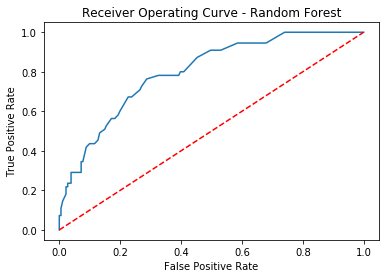

In [13]:

plt.figure()
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve - Random Forest')
plt.show()

In [14]:
rf.feature_importances_

array([2.49620609e-02, 1.97792498e-02, 4.91776338e-02, 2.50414037e-02,
       1.15820744e-02, 4.48394355e-02, 3.31590367e-02, 3.43996249e-02,
       2.10262141e-02, 2.28597481e-02, 1.17090596e-02, 2.27492658e-02,
       2.32660451e-02, 2.13640880e-02, 2.42122634e-02, 5.47700629e-02,
       1.72262341e-02, 2.00071919e-02, 2.66460606e-02, 2.58633725e-02,
       2.64953891e-02, 1.94168639e-02, 2.13963399e-02, 3.16115592e-02,
       3.26751172e-02, 5.48134337e-02, 2.12118761e-02, 3.13773654e-02,
       3.38814080e-02, 2.01387243e-02, 3.00398857e-02, 1.37181713e-02,
       2.70034199e-02, 2.43829718e-02, 8.16592775e-03, 2.49935963e-02,
       1.94449547e-03, 3.12724915e-04, 4.88381727e-03, 8.55906424e-04,
       1.67970851e-03, 4.47552023e-03, 7.41705656e-03, 0.00000000e+00,
       0.00000000e+00, 3.87082323e-04, 1.08948060e-03, 3.42811133e-03,
       3.10022207e-03, 4.03959145e-04, 7.01090514e-04, 2.59903822e-04,
       4.15660059e-05, 1.14344949e-03, 0.00000000e+00, 0.00000000e+00,
      

In [15]:
fea= sepsis_features.columns.tolist()
fea.remove('death_period')
#fea

In [16]:
res = pd.DataFrame()
res['columns'] = sepsis_features[cls].columns.tolist()
res['vals'] = rf.feature_importances_

In [25]:
res = res.sort_values('vals',ascending = False)
res

,columns,vals
25,Phosphate,0.054813
15,Lactate,0.054770
2,Anion Gap,0.049178
5,Bicarbonate,0.044839
7,"Calcium, Total",0.034400
28,RDW,0.033881
6,"Bilirubin, Total",0.033159
24,PTT,0.032675
23,PT,0.031612
27,Potassium,0.031377


In [18]:
import warnings
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

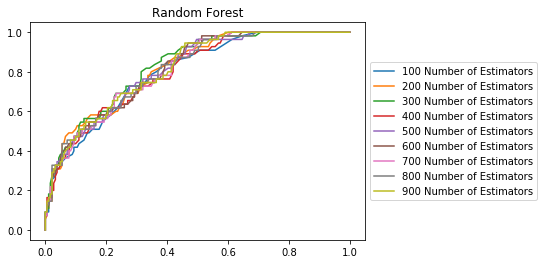

In [19]:

#Finding the ROC on increasing the variables according to their importance. Considering number of trees as 100
import sklearn.metrics as metrics
rf = dict()
probs_rf = dict()
fpr_rf = dict()
tpr_rf = dict()
thresholds_rf = dict()
auc_rf = dict()
Auc =[]
Number_of_Estimators =[]
for n in range(100, 1000, 100):
    rf[n]=RandomForestClassifier(n_estimators =n)
    rf[n].fit(tr[cls],tr['death_period'])
    probs_rf[n]=rf[n].predict_proba(ts[cls])[:,1]
    fpr_rf[n],tpr_rf[n],thresholds_rf[n] = metrics.roc_curve(ts['death_period'],probs_rf[n])
    auc_rf[n]=auc(fpr_rf[n],tpr_rf[n])
    Auc.append(auc_rf[n])
    Number_of_Estimators.append(n)
    plt.title('Random Forest')
    plt.plot(fpr_rf[n], tpr_rf[n],label = "{} Number of Estimators".format(n))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

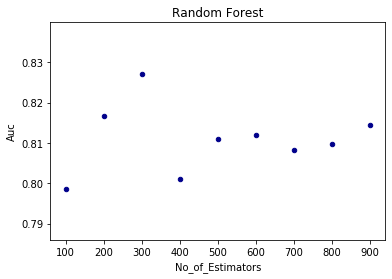

In [20]:
aucperf= pd.DataFrame({'No_of_Estimators':Number_of_Estimators,'Auc':Auc})
aucperf.plot.scatter(x='No_of_Estimators',y='Auc',c='DarkBlue',title = 'Random Forest')

In [22]:
tr_results = []
ts_results = []
for i in range(10,200,10):
    rf = RandomForestClassifier(n_estimators = i,n_jobs = -1)
    rf.fit(tr[cls],tr['death_period'])
    train_pred = rf.predict(tr[cls])
    fpr,tpr,thresholds = roc_curve(tr['death_period'],train_pred)
    roc_auc = auc(fpr,tpr)
    tr_results.append(roc_auc)
#ROC for test set on changing number of trees    
    Y_proba = rf.predict_proba(ts[cls])[:,1]
    fpr,tpr,thresholds = roc_curve(ts['death_period'],Y_proba)
    roc_auc = auc(fpr,tpr)
    ts_results.append(roc_auc)

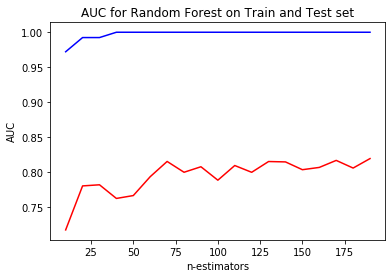

In [23]:

line1 = plt.plot(list(range(10,200,10)),tr_results,'b',label = "Train AUC")
line2 = plt.plot(list(range(10,200,10)),ts_results,'r',label = "Test AUC")
plt.xlabel('n-estimators')
plt.ylabel('AUC')
plt.title('AUC for Random Forest on Train and Test set')
plt.show()

In [44]:
#GridSearch cross validation for logistic regresssion
from sklearn.model_selection import GridSearchCV
log_reg = LogisticRegression(solver="liblinear",max_iter=200)
grid = {"penalty" : ["l1","l2"], "C" : np.arange(10,100,5)}
log_reg_cv = GridSearchCV(log_reg, grid, cv = 5)
log_reg_cv.fit(tr[cls],tr['death_period'])
print("Tuned hyperparameter: {}".format(log_reg_cv.best_params_))
print("Best score: {}".format(log_reg_cv.best_score_))

Tuned hyperparameter: {'C': 30, 'penalty': 'l1'}
Best score: 0.8227231791061579


In [69]:
logreg_best = LogisticRegression(C = 30, penalty = "l1",solver = "liblinear")
logreg_best.fit(tr[cls],tr['death_period'])



LogisticRegression(C=30, penalty='l1', solver='liblinear')

In [51]:
probs = logreg_best.predict_proba(ts[cls])[:,1]

In [73]:
y_test_preds = logreg_best.predict_proba(ts[cls])[:,1]

In [61]:
fpr,tpr,thresholds = roc_curve(ts['death_period'],probs)
#auc(fpr,tpr)


In [74]:

fpr_test, tpr_test, thresholds_tets = roc_curve(ts['death_period'], y_test_preds)


In [76]:
def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

In [ ]:
thresh = 0.3
auc_test = roc_auc_score(ts['death_period'], y_test_preds)
print('Test AUC:%.3f'%auc_test)
print('Test accuracy:%.3f'%calc_accuracy(ts['death_period'], y_test_preds,thresh))
print('Test recall:%.3f'%calc_recall(ts['death_period'], y_test_preds,thresh))
print('Test precision:%.3f'%calc_precision(ts['death_period'], y_test_preds,thresh))
print('Test specificity:%.3f'%calc_specificity(ts['death_period'], y_test_preds,thresh))

print('Test prevalence:%.3f'%calc_prevalence(ts['death_period']))



plt.plot(fpr_test, tpr_test,'b-',label = 'Test AUC: %.2f'%auc_test)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

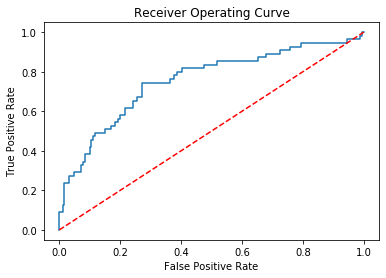

In [62]:
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve')
plt.show()

In [125]:

parameter_optimizationR={'criterion':('gini','entropy'),
                       'max_depth':(1,3,5,7,10), 'max_features':('auto','log2'),'n_estimators':(10,20,30,50,70)}
randomforest_gridcv=GridSearchCV(RandomForestClassifier(),parameter_optimizationR)

In [168]:

randomforest_gridcv.fit(tr[cls],tr['death_period'])

print("Tuned hyperparameter: {}".format(randomforest_gridcv.best_params_))
print("Best score: {}".format(randomforest_gridcv.best_score_))

Tuned hyperparameter: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 70}
Best score: 0.8386581109985366


In [172]:
rf_best = RandomForestClassifier(n_estimators = 70,max_depth = 10,max_features = 'auto',criterion = 'gini')
rf_best.fit(tr[cls],tr['death_period'])
probs = rf_best.predict_proba(ts[cls])[:,1]
fpr2,tpr2,thresholds = roc_curve(ts['death_period'],probs)
#auc(fpr2,tpr2)

In [173]:
y_test_preds =  rf_best.predict_proba(ts[cls])[:,1]

Test AUC:0.812
Test accuracy:0.725
Test recall:0.545
Test precision:0.429
Test specificity:0.779
Test prevalence:0.233


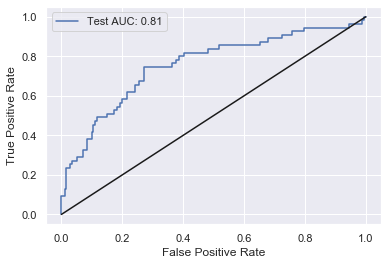

In [176]:
thresh = 0.25
auc_test = roc_auc_score(ts['death_period'], y_test_preds)
print('Test AUC:%.3f'%auc_test)
print('Test accuracy:%.3f'%calc_accuracy(ts['death_period'], y_test_preds,thresh))
print('Test recall:%.3f'%calc_recall(ts['death_period'], y_test_preds,thresh))
print('Test precision:%.3f'%calc_precision(ts['death_period'], y_test_preds,thresh))
print('Test specificity:%.3f'%calc_specificity(ts['death_period'], y_test_preds,thresh))

print('Test prevalence:%.3f'%calc_prevalence(ts['death_period']))



plt.plot(fpr_test, tpr_test,'b-',label = 'Test AUC: %.2f'%auc_test)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [153]:
#gdb.feature_importances_
res = pd.DataFrame()
res['columns'] = tr[cls].columns.tolist()
res['vals'] = rf_best.feature_importances_
res = res.sort_values('vals',ascending = False)

No handles with labels found to put in legend.


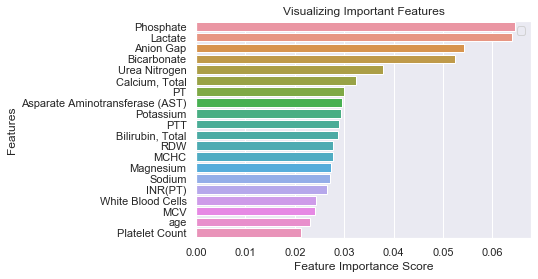

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x="vals", y= "columns", data = res[:20])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Gradient Boosting Without Tuning

In [89]:
from sklearn.ensemble import GradientBoostingClassifier
my_random_state=42
gdb= GradientBoostingClassifier(random_state=my_random_state)
my_random_state=42
gdb.fit(tr[cls],tr['death_period'])
model = gdb


In [ ]:
y_test_preds = model.predict_proba(ts[cls])[:,1]

Test AUC:0.796
Test accuracy:0.801
Test recall:0.164
Test precision:0.900
Test specificity:0.994
Test prevalence:0.233


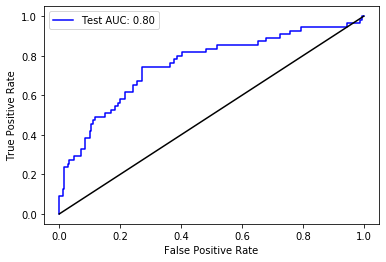

In [90]:
thresh = 0.5
auc_test = roc_auc_score(ts['death_period'], y_test_preds)
print('Test AUC:%.3f'%auc_test)
print('Test accuracy:%.3f'%calc_accuracy(ts['death_period'], y_test_preds,thresh))
print('Test recall:%.3f'%calc_recall(ts['death_period'], y_test_preds,thresh))
print('Test precision:%.3f'%calc_precision(ts['death_period'], y_test_preds,thresh))
print('Test specificity:%.3f'%calc_specificity(ts['death_period'], y_test_preds,thresh))

print('Test prevalence:%.3f'%calc_prevalence(ts['death_period']))



plt.plot(fpr_test, tpr_test,'b-',label = 'Test AUC: %.2f'%auc_test)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Gradient Boosting with Tuning 

In [200]:
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import fbeta_score,accuracy_score,make_scorer

#Initialize the classifier
clf = GradientBoostingClassifier(random_state=my_random_state)

# Create the parameters list you wish to tune
# Multiple parameters were used for optimization. All the parameters that were used for optimization are listed here.
parameters = {'max_depth':[None,3,5,8,16],'min_samples_split':[2,4],'max_features':[None,5,10,15,20,30],'min_samples_leaf':[1,5,11,50],'n_estimators':[50,100],'learning_rate':[0.01,0.05,0.1] }

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, param_grid=parameters,scoring=scorer,n_jobs=8)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(tr[cls],tr['death_period'])

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(tr[cls],tr['death_period'])).predict(ts[cls])
best_predictions = best_clf.predict(ts[cls])



KeyboardInterrupt: 

In [159]:
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(ts['death_period'], predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(ts['death_period'], predictions, beta = 0.5)))
#print "\nOptimized Model\n------"
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(ts['death_period'], best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(ts['death_period'], best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8008
F-score on testing data: 0.5346
Final accuracy score on the testing data: 0.8093
Final F-score on the testing data: 0.5556


In [ ]:
#print "\nOptimized Model\n------"
print(")Final accuracy score on the testing data: {:.4f}".format(accuracy_score(ts['death_period'], best_predictions)))
#print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
y_test_preds = best_clf.predict_proba(ts[cls])[:,1]
thresh = 0.20
#auc_test = roc_auc_score(ts['death_period'], y_test_preds)
print('Test AUC:%.3f'%auc_test)
print('Test accuracy:%.3f'%calc_accuracy(ts['death_period'], y_test_preds,thresh))
print('Test recall:%.3f'%calc_recall(ts['death_period'], y_test_preds,thresh))
print('Test precision:%.3f'%calc_precision(ts['death_period'], y_test_preds,thresh))
print('Test specificity:%.3f'%calc_specificity(ts['death_period'], y_test_preds,thresh))

print('Test prevalence:%.3f'%calc_prevalence(ts['death_period']))

No handles with labels found to put in legend.


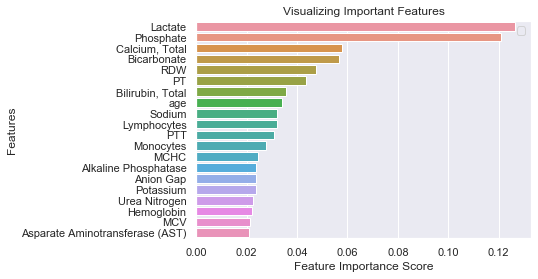

In [113]:
import seaborn as sns
sns.set(style='ticks')
sns.set_context("notebook", font_scale=1)
sns.set_style("darkgrid")
features = tr[cls]
feature_importance_df = pd.DataFrame({'feature_name': features.columns, 'feature_importance': clf.feature_importances_})
feature_importance_df.sort_values(['feature_importance'],ascending=False,inplace=True)

#fig,ax1 = plt.subplots(1, 1,figsize=(24,10),gridspec_kw={'hspace':0.4})

sns.barplot(x="feature_importance", y= "feature_name", data = feature_importance_df[:20])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()



## Feature Selection

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
mic = mutual_info_classif(tr[cls], tr['death_period'])
mic
s = pd.DataFrame()
s['att'] = cls
s['mic'] = mic
chi2 = chi2(tr[cls],tr['death_period'])
s['chi2'] = chi2[0]

In [ ]:
rf200=RandomForestClassifier(n_estimators=100)
Auc =[]
No_of_Attributes =[]
for n in range(5, 100, 5):
    cols_sel_mic=s.sort_values('mic', ascending=False)['att'][:n]
    rf200.fit(tr[cols_sel_mic],tr['death_period'])
    probs_rf200=rf200.predict_proba(ts[cols_sel_mic])
    fpr_rf200, tpr_rf200, thresholds_rf200 = roc_curve(ts['death_period'],probs_rf200[:,1])
    auc_rf200=auc(fpr_rf200,tpr_rf200)
    Auc.append(auc_rf200)
    No_of_Attributes.append(n)
    plt.title('Random Forest')
    plt.plot(fpr_rf200, tpr_rf200,label =" {} Number of attributes".format(n))
    plt.legend(loc='Right')

In [ ]:
aucperf= pd.DataFrame({'No_of_Attributes':No_of_Attributes,'Auc':Auc})
aucperf.plot.scatter(x='No_of_Attributes',y='Auc',c='DarkBlue',title = 'Random Forest')